In [1]:
import sys
import datacube
import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import os
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [28]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000

lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2007-01-01', '2007-12-31')
resolution = (-25, 25)
landsat_goodquality_prop = 0.1

ndsi_threshold = 0.4
ndvi_threshold = 0.3
ndwi_threshold = 0.15

In [29]:
#x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
# query = {'x': (x - buffer_m, x + buffer_m),
#          'y': (y - buffer_n, y + buffer_n),    
#          'time': time_range,
#          'crs': 'EPSG:3577',
#          'output_crs': 'EPSG:3577',
#          'resolution': resolution}

x, y = geometry.point(lon1, lat1, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m1, x + buffer_m1),
         'y': (y - buffer_m1, y + buffer_m1),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [57]:

# # landsat_ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query)
# landsat_ds1 = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query1)
# # landsat_ds
# landsat_ds1

landsat_ds1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1, 
                                               sensors=['ls5', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1', 'swir2'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)


Loading ls5
    Loading 23 filtered ls5 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


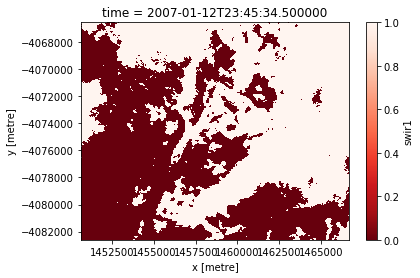

In [58]:
valid_ds = np.isfinite(landsat_ds1.swir1)
valid_ds.isel(time=1).plot(cmap='Reds_r')

In [32]:
len(landsat_ds1.time)

23

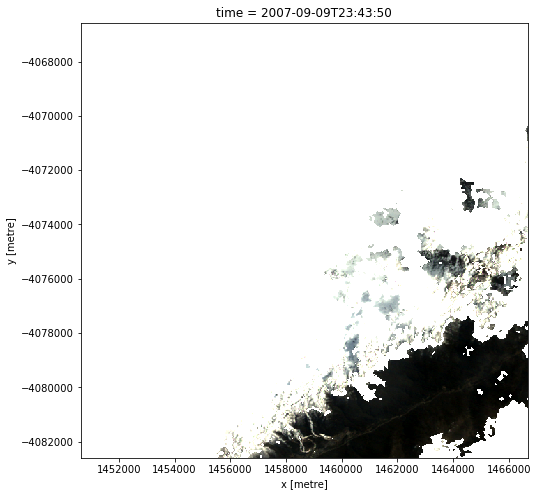

In [59]:
i=21
landsat_ds1[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, figsize=(8,8))

In [11]:
timestep='2014_09_19'

a = 
write_geotiff('truecol_'+timestep+'.tif', landsat_ds[['red', 'green', 'blue']].isel(time=0))

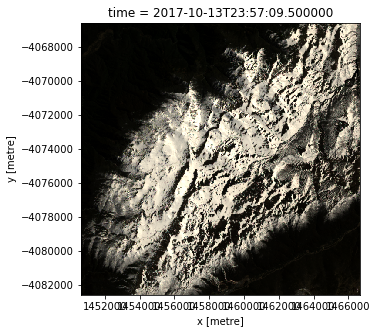

In [30]:
# landsat_ds1[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(5,5))

In [12]:
valid_ds = np.isfinite(landsat_ds1.swir1)
#valid_ds.isel(time=11).plot(cmap='Reds_r')
# np.count_nonzero(valid_ds.isel(time=5))
len(valid_ds)

17

In [61]:
ndsi_ds = (landsat_ds1.green - landsat_ds1.swir1) / (landsat_ds1.green + landsat_ds1.swir1)
ndvi_ds = (landsat_ds1.nir - landsat_ds1.red) / (landsat_ds1.nir + landsat_ds1.red)
ndwi_ds = (landsat_ds1.green - landsat_ds1.nir)/(landsat_ds1.green + landsat_ds1.nir)

In [62]:
swir1_threshold = 1500
snow_swir2 = landsat_ds1.swir2 < 1500

In [63]:
snow_ds = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds &nowater_ds #& snow_swir2

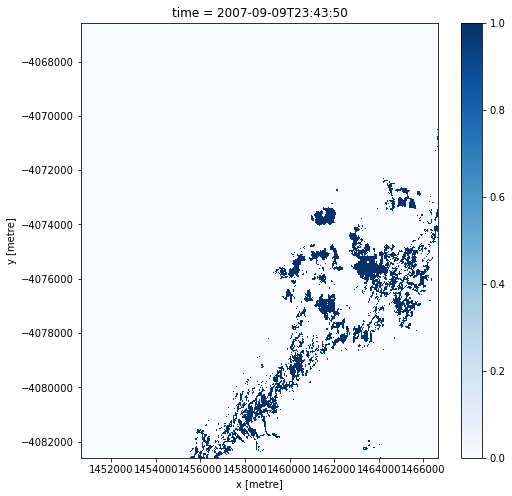

In [64]:
snow_ds.isel(time=i).plot(cmap='Blues', figsize=(8,8))

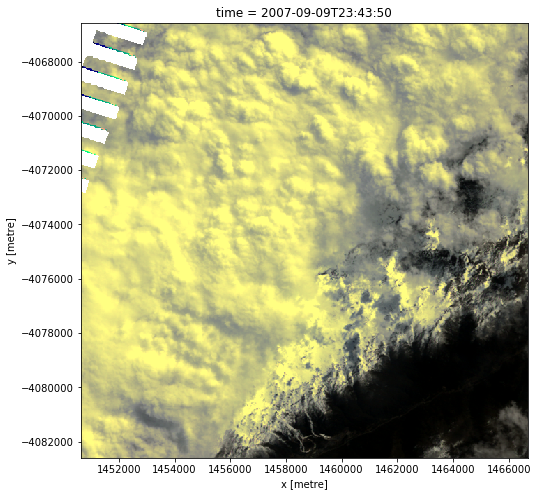

In [47]:
landsat_ds1[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, figsize=(8,8))

In [15]:
#len(snow_ds.time)
np.count_nonzero(snow_ds.isel(time=5))

0

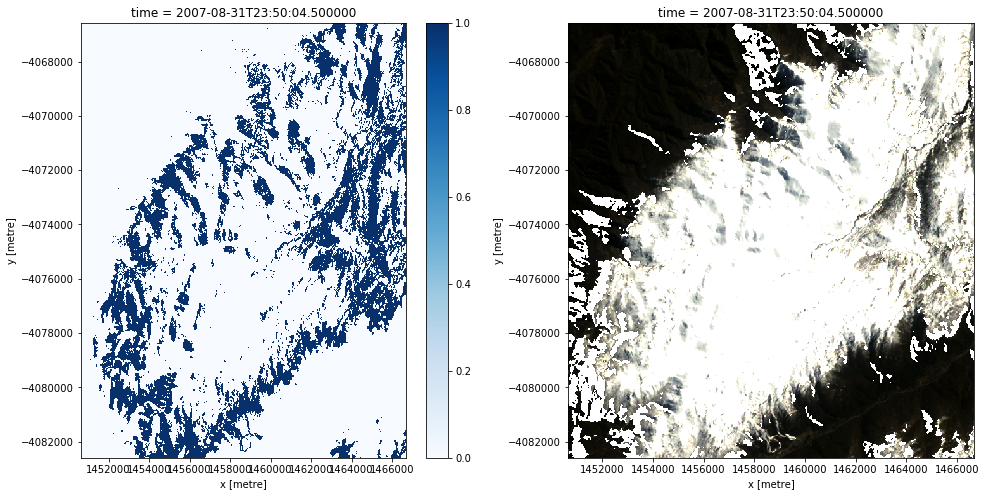

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (16, 8)
                        )
i=16
snow_ds.isel(time=i).plot(cmap='Blues', ax=axes[0]) #85
landsat_ds1[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])

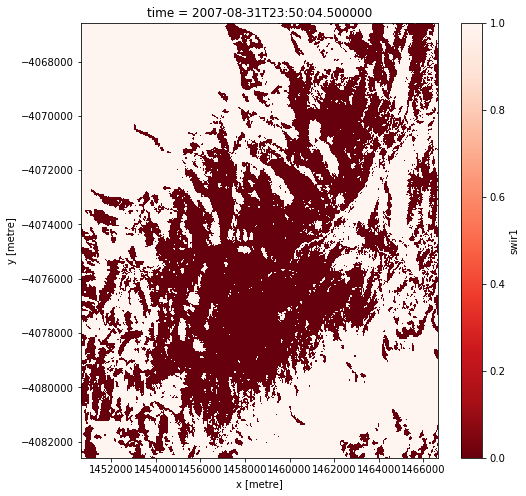

In [21]:
valid_ds.isel(time=16).plot(figsize=(8, 8),cmap='Reds_r')

In [31]:
# snow_ds=snow_ds.squeeze
snow_ds = snow_ds.drop('time')

In [33]:
# snow_ds=snow_ds.squeeze()
transform, projection = SpatialTools.geotransform(snow_ds, (snow_ds.x, snow_ds.y), epsg=3577)
SpatialTools.array_to_geotiff('out_snow.tif',
              snow_ds.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

This function is written for use with the GDAL run 'array_to_geotiff' function and should be used with extreme caution elsewhere.


In [8]:
# landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
#                                                query=query, 
#                                                sensors=['ls8'],
#                                                bands_of_interest=['red', 'green','blue', 'nir', 'swir1'],
#                                                masked_prop=landsat_goodquality_prop, 
#                                                ls7_slc_off=True)

# print(landsat_ds)

In [7]:
# landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(8,8))

In [44]:
landsat_ds.to_netcdf('landsat_ds.nc')
#type(landsat_ds)

TypeError: Invalid value for attr: EPSG:3577 must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files

In [43]:
DEADataHandling.write_dataset_to_netcdf(landsat_ds,filename='landsat_ds.nc')

AttributeError: 'DataArray' object has no attribute 'units'

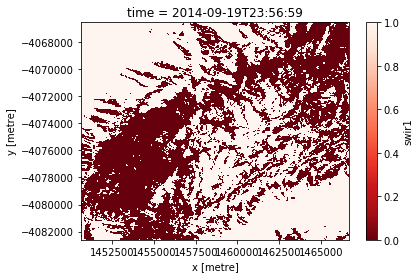

In [23]:
valid_ds = np.isfinite(landsat_ds.swir1)


# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(ncols=2, 
#                          figsize = (16, 8)
#                         )

valid_ds.isel(time=0).plot(cmap='Reds_r') #85
